In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import additional_functions as af
import ast
import yaml
from scipy.ndimage import zoom
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
%matplotlib inline


In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
saving_path = '/nemo/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/figs'
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
all_bcs_with_source = {}
barcodes_no_source = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    barcodes_no_source[mouse] = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded.pkl"
    )
    all_bcs_with_source[mouse]= barcodes_across_sample
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = af.load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 151.30it/s]
/tmp/ipykernel_3081898/3439394790.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


In [3]:
# mcc = MouseConnectivityCache(resolution=10)
# rsp = mcc.get_reference_space()
# cortex_mask = rsp.make_structure_mask([688], direct_only=False) #688 is id for whole  cortex
# # download_allen = pathlib.Path(
# #     "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
# # )
# # allen anterograde tracing datasets with more than 75% injection site AUDp

# experiment_id_a = 120491896  # AUDp
# experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
# experiment_id_c = 100149109  # AUDp and AUDd

# expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
# expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
# expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
# ids = [120491896, 116903230, 100149109]
# fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
# expts = [expt_a, expt_b, expt_c]
# i =0
# for ax, expt in zip(axes, expts):
#     expt_cortex= expt *cortex_mask
#     projection_max = proj_top.project_volume(expt_cortex)
#     to_look = np.log10(projection_max+1).T
#     to_look = np.flip(to_look, axis=1)
#     #plt.imshow(to_look, cmap='magma')
#     im = ax.imshow(to_look, cmap='magma')
#     ax.axis("off")
#     fig.colorbar(im, ax=ax, label="log10(projection density (A.U.)", fraction=0.03, pad=0.04)
#     for k, boundary_coords in bf_left_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     for k, boundary_coords in bf_right_boundaries.items():
#         ax.plot(*boundary_coords.T, c="white", lw=0.5)
#     ax.set_title(f"Bulk GFP tracing {[ids][0][i]}")
#     i += 1
# fig.savefig(f"{saving_path}/allen_bulk_flatmaps.svg", format="svg")
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_3081898/3740993789.py:29: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
/tmp/ipykernel_3081898/3740993789.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


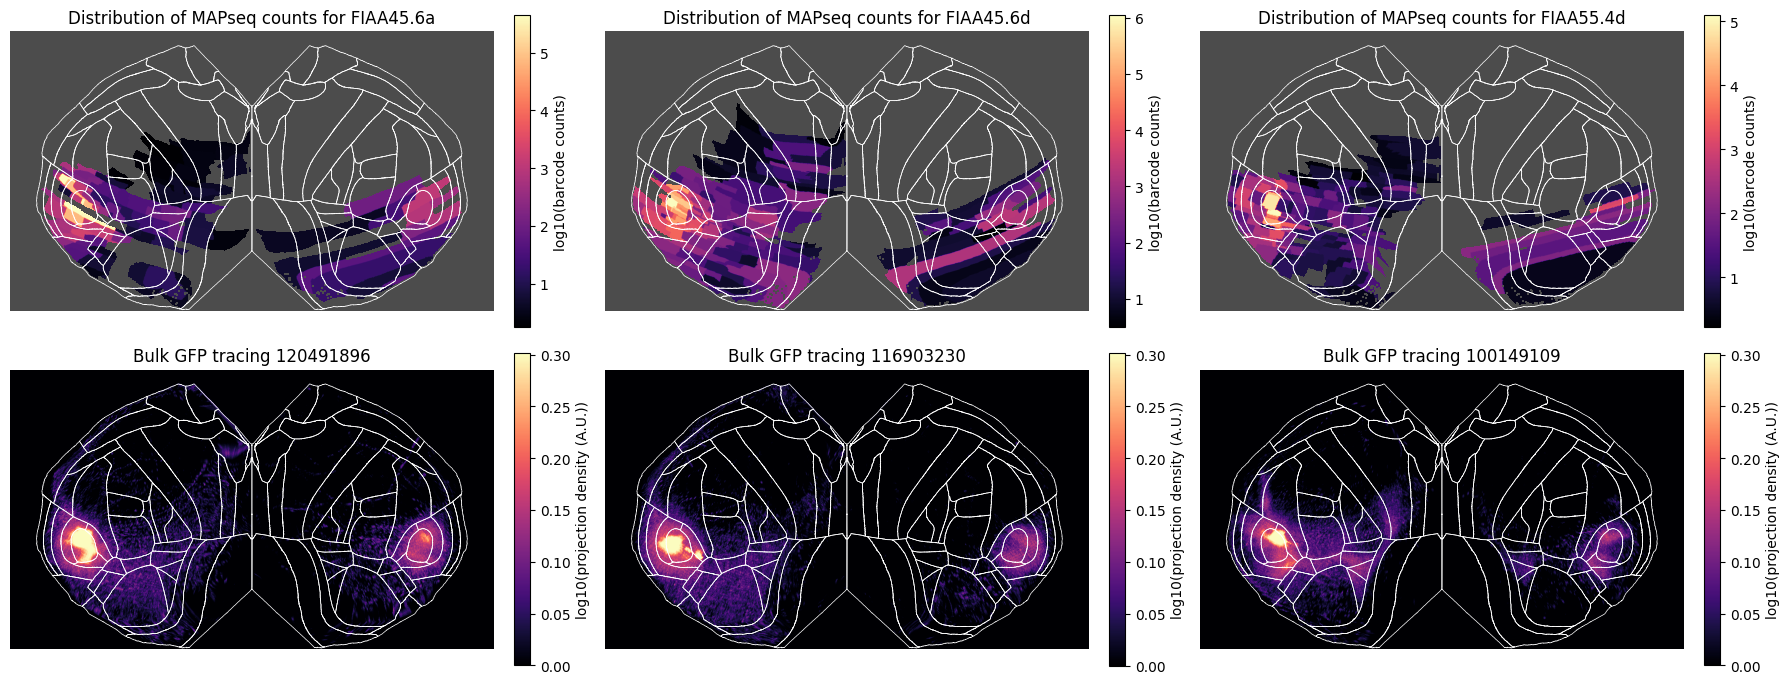

In [3]:
#get rid of overlapping rois due to flatmap artifacts
fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # Two rows, three columns
all_mice_flat = {}

# First row: MAPseq counts for each mouse
for i, (ax, mouse) in enumerate(zip(axes[0], mice)):
    #ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    roi_to_look = roi_dict[mouse]
    all_flatmap = proj_top.project_volume(roi_to_look)
    rebuilding_all_flatmap = np.zeros_like(all_flatmap)
    barcodes_across_sample = barcodes_dict[mouse]
    for roi in barcodes_across_sample.columns:
        binary_roi_array = np.where(roi_to_look == roi, roi, 0)
        flat_projection = proj_top.project_volume(binary_roi_array)
        rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]
    barcodes_across_sample = barcodes_dict[mouse]
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

    # Compute total counts and log-transform
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
    new_mat = np.flip(new_mat, axis=1)  # Adjust orientation
    all_mice_flat[mouse] = new_mat

    # Configure the colormap
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # NaN values as grey

    # Plot the heatmap
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(barcode counts)", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Distribution of MAPseq counts for {mouse}")

# Second row: GFP tracing
# Set up MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False)  # 688 = cortex ID

experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
expts = [expt_a, expt_b, expt_c]
ids = [experiment_id_a, experiment_id_b, experiment_id_c]

# Second row: GFP projections for each experiment
for i, (ax, expt) in enumerate(zip(axes[1], expts)):
    expt_cortex = expt * cortex_mask
    projection_max = proj_top.project_volume(expt_cortex)
    to_look = np.log10(projection_max + 1).T
    to_look = np.flip(to_look, axis=1)  # Adjust orientation

    # Plot projection density
    im = ax.imshow(to_look, cmap='magma')
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(projection density (A.U.))", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Bulk GFP tracing {ids[i]}")

# Adjust layout and display
plt.tight_layout()
fig.savefig(f"{saving_path}/bulk_MAPseq_and_allen_flatmaps.svg", format="svg")
plt.show()


/tmp/ipykernel_3081898/903800537.py:17: RuntimeWarning: divide by zero encountered in log10
  raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_3081898/903800537.py:30: RuntimeWarning: Mean of empty slice
  mean_z_normalized = np.nanmean(all_mice_array, axis=0)
/tmp/ipykernel_3081898/903800537.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


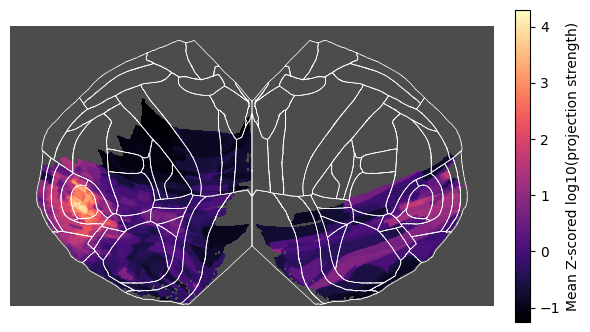

In [4]:

all_mice_normalized = []

# Iterate through mice and z-normalize data
for mouse in mice:
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    valid_data = raw_data[raw_data >= 0]  
    mean = np.mean(valid_data)
    std = np.std(valid_data)
    z_normalized = (raw_data - mean) / std
    z_normalized[raw_data < 0] = np.nan 

    
    all_mice_normalized.append(z_normalized)

all_mice_array = np.stack(all_mice_normalized, axis=0)

mean_z_normalized = np.nanmean(all_mice_array, axis=0)
mean_z_normalized = np.flip(mean_z_normalized, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

im = ax.imshow(mean_z_normalized, cmap=cmap)
ax.axis("off")

fig.colorbar(im, ax=ax, label="Mean Z-scored log10(projection strength)", fraction=0.03, pad=0.04)

for k, boundary_coords in bf_left_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

#ax.set_title("Mean Z-scored log10(projection strength)")

plt.tight_layout()
fig.savefig(f"{saving_path}/A1_MAPseq_counts_flatmap.svg", format="svg")
plt.show()


Now plot Vc area mean AP soma position 

In [4]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [5]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
def get_AP_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found
# mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
key = 'homog_across_cubelet'
combined_mice_dict = {}
for mouse in mice:
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    barcodes = barcodes[barcodes.astype(bool).sum(axis=1)>0]
    combined_mice_dict[mouse] = barcodes



In [6]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_AUDp[:, 0])
min_y = np.min(indices_AUDp[:, 0])
AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1


#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mouse_dict_AP_source = {}
mouse_barcodes_by_source = {}
mouse_dict_A1_coords = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    AP_position_dict = {}
    A1_coord_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    #indices = which_mice[which_mice['mice'] == mouse].index
    #barcodes = barcodes.loc[indices]
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = max_y - centroid[0] #AP_midpoint_A1
        A1_coord_dict[sample] = centroid
    mouse_dict_AP_source[mouse]=AP_position_dict
    mouse_dict_A1_coords[mouse]=A1_coord_dict

In [7]:
# def get_area_volumes(barcode_table_cols, lcm_directory, area_threshold=0.1):
#     """
#     Function to get volumes of each registered brain area from each LCM sample
#     Args:
#         barcode_table_cols: list of column names of the barcode matrix
#         lcm_directory: path to where the lcm_directory is
#         area_threshold (int): minimum value that defines a brain area within a cubelet
#     Returns: area vol pandas dataframe
#     """
#     sample_vol_and_regions = pd.read_pickle(
#         lcm_directory / "sample_vol_and_regions.pkl"
#     )
#     sample_vol_and_regions = sample_vol_and_regions[
#         sample_vol_and_regions["ROI Number"].isin(barcode_table_cols)
#     ]
#     sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
#         ast.literal_eval
#     )
#     sample_vol_and_regions["breakdown"] = sample_vol_and_regions["breakdown"].apply(
#         ast.literal_eval
#     )
#     all_areas_unique_acronymn = np.unique(
#         sample_vol_and_regions["regions"].explode().to_list()
#     )
#     all_area_df = pd.DataFrame(
#         index=barcode_table_cols, columns=all_areas_unique_acronymn
#     )
#     for column in barcode_table_cols:
#         # all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
#         index = sample_vol_and_regions[
#             sample_vol_and_regions["ROI Number"] == column
#         ].index
#         reg = pd.DataFrame()
#         reg["regions"] = [i for i in sample_vol_and_regions.loc[index, "regions"]][0]
#         reg["fraction"] = [i for i in sample_vol_and_regions.loc[index, "breakdown"]][0]
#         reg["vol_area"] = (
#             reg["fraction"] * sample_vol_and_regions.loc[index, "Volume (um^3)"].item()
#         )

#         for _, row in reg.iterrows():
#             all_area_df.loc[column, row["regions"]] = row["vol_area"]
#     group_areas = {"Contra": all_area_df.filter(like="Contra").columns}
#     areas_grouped = all_area_df.copy()
#     for group, columns in group_areas.items():
#         areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
#         columns = [value for value in columns if value in all_area_df.columns]
#         areas_grouped = areas_grouped.drop(columns, axis=1)
#     nontarget_list = ["fiber tracts", "root"]
#     nontarget_list = [value for value in nontarget_list if value in all_area_df.columns]
#     areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)
#     areas_only_grouped = areas_only_grouped.apply(
#         lambda row: row.where(row >= area_threshold * row.sum(), np.nan), axis=1
#     )
#     areas_only_grouped = areas_only_grouped.fillna(0)
#     areas_only_grouped = areas_only_grouped.loc[
#         :, (areas_only_grouped != 0).any(axis=0)
#     ]

#     return areas_only_grouped

In [7]:

#for each pixel compute mean soma AP position
vis_areas =  ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
#first lets locate the 
vis_roi_dict = {}
all_AP_dict = {}
vis_mean_dict = {}
barcodes_per_sample = {}
which_soma = pd.DataFrame(columns = ['Mouse', 'Sample', 'AP_position', 'Coords'])

for mouse in mice:
    sample_num_dict = {}
    sample_3d = roi_dict[mouse].copy()
    proj_path = (
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}")
    barcodes = pd.read_pickle(f"{proj_path}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    lcm_dir = proj_path + "/LCM"
    area_matrix = af.get_area_volumes(barcode_table_cols=barcodes.columns, lcm_directory=pathlib.Path(lcm_dir), area_threshold=0.1)
    vis_samples = area_matrix[area_matrix[vis_areas].astype(bool).sum(axis=1)>0].index.to_list()
    frac = area_matrix.div(area_matrix.sum(axis=1), axis=0)
    frac_filtered = frac.loc[(frac[vis_areas].gt(0).any(axis=1)) & (frac['AUDp'] > 0.1)].index
    all_VIS_ROI = [sample for sample in vis_samples if sample in barcodes.columns and sample not in frac_filtered]
    mask = np.isin(sample_3d, all_VIS_ROI)
    sample_3d[~mask] = 0
    vis_roi_dict[mouse] =sample_3d
    # bl = np.full(sample_3d.shape, np.nan, dtype=float)
    sample_dict = {}
    the_soma_samples = []
    for sample in vis_samples:
        bcs = barcodes.copy()
        vis_proj = bcs[bcs[sample].astype(bool)>0]
        soma = pd.DataFrame(vis_proj.idxmax(axis=1))
        soma['AP_position'] = soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source[mouse]), axis=1)
        # mean_AP = soma['AP_position'].mean()
        # bl[sample_3d == sample] = mean_AP
        # sample_num_dict[sample] = len(vis_proj)
        sample_dict[sample] = soma['AP_position']
        for soma_sample in vis_proj.idxmax(axis=1).unique():
            if soma_sample not in the_soma_samples:
                the_soma_samples.append(soma_sample)
    for sample_to_look in the_soma_samples:
        new_row = pd.DataFrame({'Mouse': [mouse], 'Sample': [sample_to_look], 'AP_position': [mouse_dict_AP_source[mouse][sample_to_look]*25], 'Coords': [mouse_dict_A1_coords[mouse][sample_to_look]]})
        which_soma = pd.concat([which_soma, new_row])    
    # barcodes_per_sample[mouse] = sample_num_dict
    # vis_mean_dict[mouse] = bl
    all_AP_dict[mouse] = sample_dict

which_soma.reset_index(inplace=True)        
    

In [9]:
arrays = list(vis_roi_dict.values()) 
bool_arrays = [(arr > 0) for arr in arrays]
combined_bool_any = np.any(bool_arrays, axis=0)
coords = np.argwhere(combined_bool_any)
some_mouse = mice[0]
master_3d = np.full(vis_roi_dict[some_mouse].shape, np.nan, dtype=float)
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
for (i, j, k) in coords:
    value_list = []
    for mouse in mice:
        roi_to_look = vis_roi_dict[mouse]
        sample = roi_to_look[i, j, k]
        if sample>0:
            list_of_pos = all_AP_dict[mouse][sample].to_list()
            if len(list_of_pos)>2:
                value_list.extend(list_of_pos)
    master_3d[i, j, k] = np.mean(value_list)*25
                

/camp/home/turnerb/.conda/envs/MAPseq_processing_py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/camp/home/turnerb/.conda/envs/MAPseq_processing_py39/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
which_soma['2d_coords_y'] = None
which_soma['2d_coords_x'] = None
for mouse in mice:
    mouse_2d = proj_top.project_volume(roi_dict[mouse])
    to_looksoma = mouse_2d.T
    to_looksoma = np.flip(to_looksoma, axis=1)
    #mouse_only = which_soma[which_soma['Mouse']==mouse]
    for ind, row in which_soma.iterrows():
        if row['Mouse'] == mouse:
            sample = row['Sample']
            where_the_sample = np.argwhere(to_looksoma==sample)
            which_2d_coord = np.mean(where_the_sample, axis=0)
            which_soma.loc[ind, '2d_coords_y'] = which_2d_coord[0]
            which_soma.loc[ind, '2d_coords_x'] = which_2d_coord[1]
    


/camp/home/turnerb/.conda/envs/MAPseq_processing_py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/camp/home/turnerb/.conda/envs/MAPseq_processing_py39/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/tmp/ipykernel_1342722/2192263131.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow").copy()


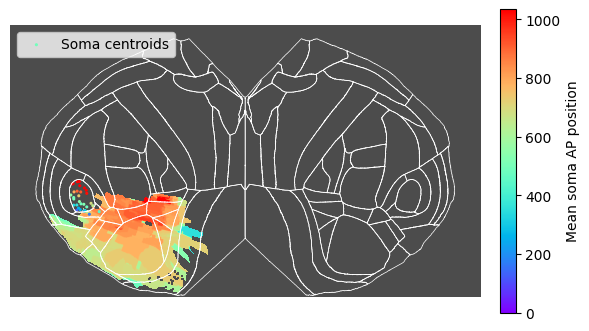

In [12]:
clean_volume = np.nan_to_num(master_3d, nan=-np.inf)
clean_volume_max = proj_top.project_volume(clean_volume)
to_look = clean_volume_max.T
to_look = np.flip(to_look, axis=1)
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("rainbow").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 
to_look_masked = np.where(to_look <= 0, np.nan, to_look)
im = ax.imshow(to_look_masked, cmap=cmap, vmin=0, vmax= clean_volume_max.max())
ax.axis("off")

fig.colorbar(im, ax=ax, label="Mean soma AP position", fraction=0.03, pad=0.04)
for l, boundary_coords in bf_left_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for l, boundary_coords in bf_right_boundaries.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
coords_y = which_soma['2d_coords_y'].to_numpy()  
coords_x = which_soma['2d_coords_x'].to_numpy() 
colors = which_soma['AP_position'].to_numpy()

sc = ax.scatter(coords_x, coords_y, c=colors, cmap=cmap,
                vmin=0, vmax=clean_volume_max.max(), s=5, edgecolors='none', label = 'Soma centroids')

#ax.set_title("Mean Z-scored log10(projection strength)")
plt.legend()
plt.tight_layout()
fig.savefig(f"{saving_path}/mean_AP_soma_projection.svg", format="svg")
plt.show()
